In [ ]:
pip install keras-tuner


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0424 - val_loss: 0.0026
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0021 - val_loss: 9.6496e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 9.8332e-04 - val_loss: 9.0662e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 8.9361e-04 - val_loss: 7.2771e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 8.8351e-04 - val_loss: 6.7270e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 8.2691e-04 - val_loss: 6.5809e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 7.5983e-04 - val_loss: 5.9069e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.0777e-04 - val_loss: 6.0053e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 7.3466e-04 - val_loss: 5.5717e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.9599e-04 - val_loss: 5.1721e-04
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 6.5916e-04 - val_loss: 8.1073e-0

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Mean Squared Error (GRU): 96.58300060675901
Mean Absolute Error (GRU): 8.047262959911421
R2 score (GRU): 0.968169471010203
Mean Absolute Percentage Error (MAPE): 4.110248172109789%
Percentage of Correct Directional Change (POCID): 37.33905579399141%


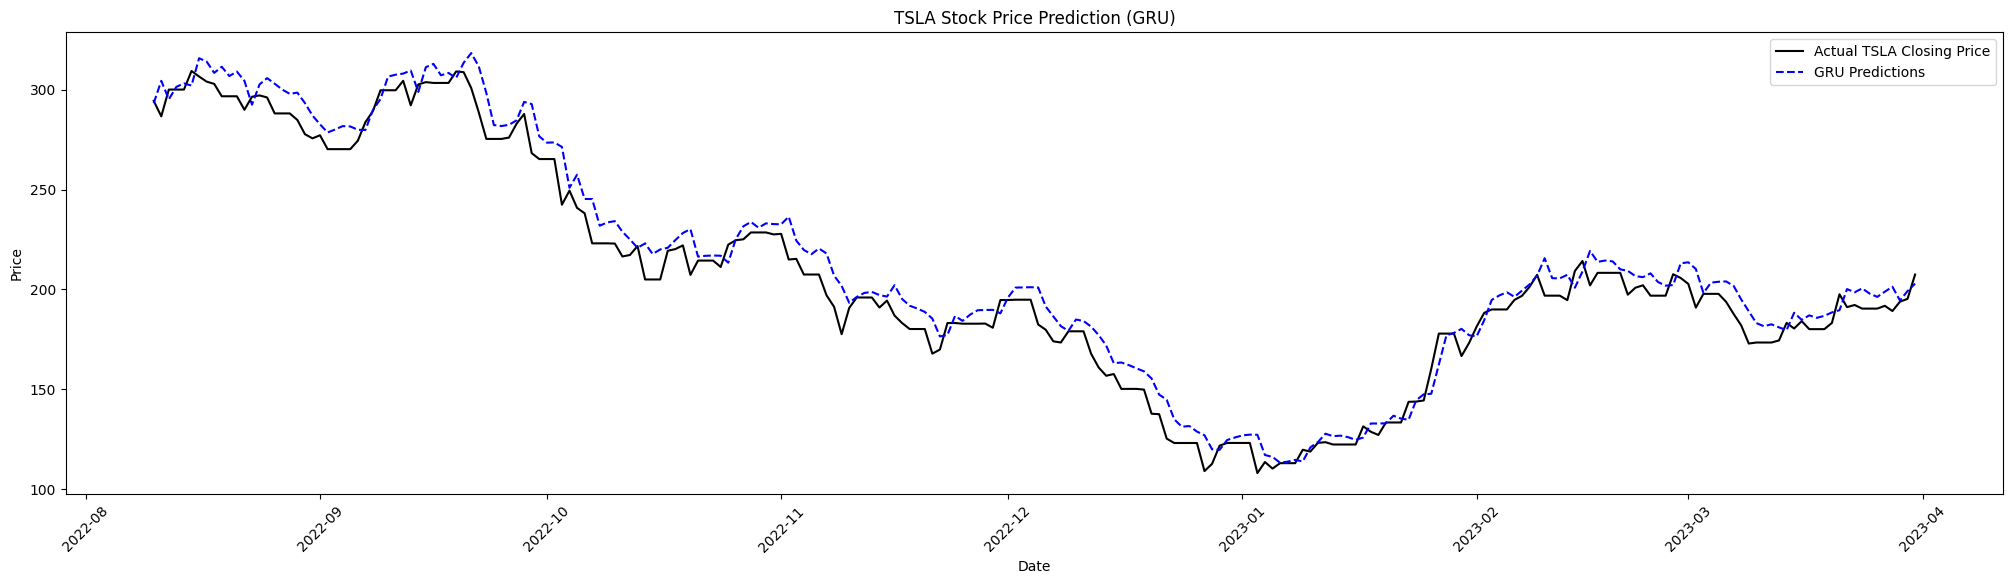

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

file_path = 'btpdataset.csv'
df = pd.read_csv(file_path)

df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.sort_values('date').reset_index(drop=True)

encoder = LabelEncoder()
df['news_sentiment'] = encoder.fit_transform(df['news_sentiment'])

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['news_sentiment', 'opening price', 'high', 'low', 'volume traded', 'closing price']])

sequence_length = 20
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])  
    y.append(scaled_data[i, -1])  
X, y = np.array(X), np.array(y)

#80-20split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

def build_gru_model(hp):
    model = Sequential()

    model.add(GRU(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(GRU(units=hp.Int('units_2', min_value=32, max_value=128, step=32)))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='gru_stock_price_prediction'
)


tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps.values}")
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

gru_predictions = best_model.predict(X_test).flatten()

gru_predictions_inverse = scaler.inverse_transform(np.column_stack([np.zeros((len(gru_predictions), 5)), gru_predictions]))[:, -1]
real_prices = scaler.inverse_transform(np.column_stack([np.zeros((len(y_test), 5)), y_test]))[:, -1]

mse = mean_squared_error(real_prices, gru_predictions_inverse)
mae = mean_absolute_error(real_prices, gru_predictions_inverse)
r2 = r2_score(real_prices, gru_predictions_inverse)
mape = np.mean(np.abs((real_prices - gru_predictions_inverse) / real_prices)) * 100
correct_direction = np.sign(np.diff(real_prices)) == np.sign(np.diff(gru_predictions_inverse))
pocid = np.mean(correct_direction) * 100

print(f'Mean Squared Error (GRU): {mse}')
print(f'Mean Absolute Error (GRU): {mae}')
print(f'R2 score (GRU): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Percentage of Correct Directional Change (POCID): {pocid}%')


test_dates = df['date'][-len(real_prices):]
plt.figure(figsize=(25, 6))
plt.plot(test_dates, real_prices, color='black', label='Actual TSLA Closing Price')
plt.plot(test_dates, gru_predictions_inverse, color='blue', linestyle='dashed', label='GRU Predictions')
plt.title('TSLA Stock Price Prediction (GRU) with Keras Tuner Hyperparameter Tuning')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()
